In [9]:
# import pickle
import json  # 存loss, acc
import random
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod
#################################################
import cv2
# import matplotlib.pyplot as plt
# import math

import os
import multiprocessing as mp
from tqdm import tqdm
# import time
#################################################
# import torch
# import torch.nn as nn
# # import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
#################################################
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.data import Dataset
print(tf.__version__)

2.6.2


In [3]:
# print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

In [37]:
resized_train_imgs = np.load(file="./data/resized_train_imgs.npy")
resized_val_imgs = np.load(file="./data/resized_val_imgs.npy")
resized_test_imgs = np.load(file="./data/resized_test_imgs.npy")
train_label = np.load(file="./data/train_label.npy")
val_label = np.load(file="./data/val_label.npy")
test_label = np.load(file="./data/test_label.npy")

def MoveColorChannel(image: np.ndarray) -> np.ndarray:
    return np.moveaxis(image, source=2, destination=0)  # reshape (H, W, C) to (C, H, W)

with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(MoveColorChannel, tqdm(resized_train_imgs))
    resized_val_imgs = pool.map(MoveColorChannel, tqdm(resized_val_imgs))
    resized_test_imgs = pool.map(MoveColorChannel, tqdm(resized_test_imgs))

# convert list to numpy.ndarray
resized_train_imgs = np.array(resized_train_imgs)
resized_val_imgs = np.array(resized_val_imgs)
resized_test_imgs = np.array(resized_test_imgs)
# list to numpy.ndarray
train_label = np.array(train_label)
val_label = np.array(val_label)
test_label = np.array(test_label)
# check the shape
print(resized_train_imgs.shape)
print(resized_val_imgs.shape)
print(resized_test_imgs.shape)
print()
print(train_label.shape)
print(val_label.shape)
print(test_label.shape)

X_train, Y_train, X_val, Y_val, X_test, Y_test = resized_train_imgs, train_label, \
                                                 resized_val_imgs, val_label, \
                                                 resized_test_imgs, test_label
# normalization
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)

def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

Y_train = MakeOneHot(Y_train, 50)
Y_val = MakeOneHot(Y_val, 50)
Y_test = MakeOneHot(Y_test, 50)

100%|██████████| 450/450 [00:00<00:00, 28293.59it/s]


(63325, 3, 32, 32)
(450, 3, 32, 32)
(450, 3, 32, 32)

(63325,)
(450,)
(450,)


In [38]:
train_dataset = Dataset.from_tensor_slices((X_train, Y_train))
val_dataset = Dataset.from_tensor_slices((X_val, Y_val))
test_dataset = Dataset.from_tensor_slices((X_test, Y_test))
BATCH_SIZE = 64
train_dataloader = train_dataset.batch(BATCH_SIZE)
val_dataloader = val_dataset.batch(BATCH_SIZE)
test_dataloader = test_dataset.batch(BATCH_SIZE)

In [39]:
class LeNet5(tf.keras.Model):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = layers.Conv2D(filters=6,
                                   kernel_size=5,
                                   strides=1,
                                   activation='relu',
                                   data_format='channels_first',
                                   input_shape=(None, 3, 32, 32))
        self.maxpool1 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.conv2 = layers.Conv2D(filters=16,
                                   kernel_size=5,
                                   strides=1,
                                   activation='relu',
                                   data_format='channels_first')
        self.maxpool2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.flatten = layers.Flatten(data_format='channels_first')
        self.fc1 = layers.Dense(units=120, activation='relu')
        self.fc2 = layers.Dense(units=84, activation='relu')
        self.fc3 = layers.Dense(units=50, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


In [36]:
# Create an instance of the LeNet-5 model
model = LeNet5()

# Define the loss function and optimizer
loss_fn = losses.CategoricalCrossentropy()
optimizer = optimizers.Adam(learning_rate=1e-3)

# Define metrics for evaluation
train_loss_metric = metrics.Mean()
train_accuracy_metric = metrics.Accuracy()
val_loss_metric = metrics.Mean()
val_accuracy_metric = metrics.Accuracy()

# Training loop
EPOCHS = 30
BATCH_SIZE = 64
# steps_per_epoch = len(x_train) // batch_size

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss_metric.reset_states()
    train_accuracy_metric.reset_states()
    val_loss_metric.reset_states()
    val_accuracy_metric.reset_states()

    with tf.GradientTape() as tape:
        for X, y in train_dataloader:
            # Forward pass
            outputs = model(X)  # probability
            pred = tf.argmax(outputs, axis=1)  # predicted label
            # Compute loss
            loss = loss_fn(y, outputs)
            
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


    # for step in range(steps_per_epoch):
    #     start = step * batch_size
    #     end = start + batch_size
    #     x_batch = x_train[start:end]
    #     y_batch = y_train[start:end]

    #     with tf.GradientTape() as tape:
    #         logits = model(x_batch, training=True)
    #         loss_value = loss_fn(y_batch, logits)
        
    #     gradients = tape.gradient(loss_value, model.trainable_variables)
    #     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss_metric(loss)
    train_accuracy_metric(y, pred)
    train_loss_list.append(train_loss_metric.result().numpy())
    train_acc_list.append(train_accuracy_metric.result().numpy())

    # Evaluation on test data
    val_loss = 0
    val_prob = model(X_val, training=False)
    val_pred = tf.argmax(val_prob, axis=1)
    val_loss = loss_fn(Y_val, val_prob)
    val_accuracy_metric(Y_val, val_pred)
    val_loss_list.append(val_loss.numpy())
    val_acc_list.append(val_accuracy_metric.result().numpy())

    if epoch % 1 == 0:
        print(f"Train Loss: {train_loss_metric.result():.4f}, Train Accuracy: {train_accuracy_metric.result():.4f}")
        print(f"Test Loss: {val_loss:.4f}, Test Accuracy: {val_accuracy_metric.result():.4f}")
        print()

Epoch 1/30
Train Loss: 3.9841, Train Accuracy: 0.0000
Test Loss: 3.9215, Test Accuracy: 0.0244

Epoch 2/30
Train Loss: 3.6614, Train Accuracy: 0.4483
Test Loss: 3.9372, Test Accuracy: 0.0200

Epoch 3/30
Train Loss: 3.3771, Train Accuracy: 1.0000
Test Loss: 3.9745, Test Accuracy: 0.0200

Epoch 4/30
Train Loss: 3.0048, Train Accuracy: 1.0000
Test Loss: 4.0548, Test Accuracy: 0.0200

Epoch 5/30
Train Loss: 2.5167, Train Accuracy: 1.0000
Test Loss: 4.2269, Test Accuracy: 0.0200

Epoch 6/30
Train Loss: 1.9215, Train Accuracy: 1.0000
Test Loss: 4.6005, Test Accuracy: 0.0200

Epoch 7/30
Train Loss: 1.2882, Train Accuracy: 1.0000
Test Loss: 5.3602, Test Accuracy: 0.0200

Epoch 8/30
Train Loss: 0.7461, Train Accuracy: 1.0000
Test Loss: 6.6676, Test Accuracy: 0.0200

Epoch 9/30
Train Loss: 0.3796, Train Accuracy: 1.0000
Test Loss: 8.5122, Test Accuracy: 0.0200

Epoch 10/30
Train Loss: 0.1740, Train Accuracy: 1.0000
Test Loss: 10.7657, Test Accuracy: 0.0200

Epoch 11/30
Train Loss: 0.0739, Train 

KeyboardInterrupt: 

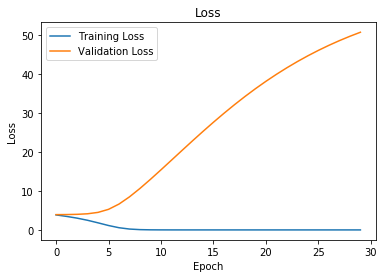

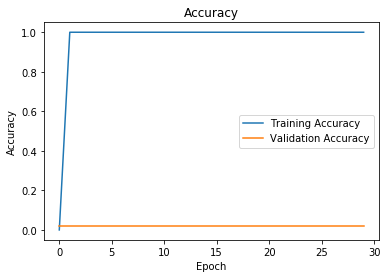

In [35]:
def draw_losses(train_losses=None, val_losses=None, test_losses=None):
    if train_losses!=None:
        plt.plot(np.arange(EPOCHS), train_losses, label='Training Loss')
    if val_losses!=None:
        plt.plot(np.arange(EPOCHS), val_losses, label='Validation Loss')
    if test_losses!=None:    
        plt.plot(np.arange(EPOCHS), test_losses, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('./pic/pytorch_model_loss.png')
    plt.show()
    
def draw_accuracy(train_acc=None, val_acc=None, test_acc=None):
    if train_acc!=None:
        plt.plot(np.arange(EPOCHS), train_acc, label='Training Accuracy')
    if val_acc!=None:
        plt.plot(np.arange(EPOCHS), val_acc, label='Validation Accuracy')
    if test_acc!=None:    
        plt.plot(np.arange(EPOCHS), test_acc, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('./pic/pytorch_model_acc.png')
    plt.show()
    
draw_losses(train_losses=train_loss_list, val_losses=val_loss_list)
draw_accuracy(train_acc=train_acc_list, val_acc=val_acc_list)

In [ ]:
# predict test dataset
pred_label = tf.argmax(model(X_test), dim=1)
print(f"Test acc: {tf.metrics.(Y_test, pred_label):.4f} %")

In [ ]:
# inference time
time_start = time.perf_counter()
acc, loss = validate(loaded_model, loss_fn, val_loader)
print("Time for PyTorch Lenet : {} s".format(time.perf_counter() - time_start))

# %timeit validate(loaded_model, loss_fn, val_loader)
# Accuracy
print('Accuracy for PyTorch Lenet : ', acc)
print('Loss for PyTorch Lenet : ', loss)


# https://zhuanlan.zhihu.com/p/337810633
flops, params = profile(loaded_model, input_size=(1, 3, 32, 32))
print('FLOPs = ' + str(flops/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')
profile()